In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from matplotlib import colors, cm
import glob
from datetime import datetime, timedelta

from numba import njit, vectorize, float32

from typing import Callable, Optional, Union, List

import hoomd
import gsd.hoomd
import freud
import schmeud
from schmeud._schmeud import dynamics as schmeud_dynamics
from schmeud._schmeud import locality as schmeud_locality

import sys
import time
import pickle
import gc
import warnings
import copy
import pathlib
from collections import defaultdict

import os
import sys

import signac

from dataclasses import dataclass
from dataclasses_json import dataclass_json

import fresnel
import PIL.Image
mpl.rcParams["figure.dpi"] = 150
mpl.rcParams["axes.labelsize"] = "xx-large"
from monk import nb, prep, pair, render, utils, workflow, grid

config = workflow.get_config()
project: signac.Project = signac.get_project(root=config['root'])
project.doc

import gudhi
from gudhi import representations

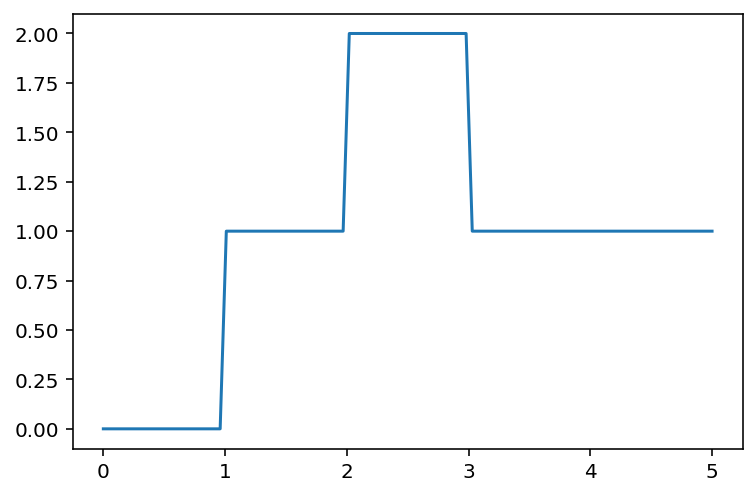

In [37]:
simp_tree = gudhi.SimplexTree()

simp_tree.insert([0], 1.0)
simp_tree.insert([1], 2.0)
simp_tree.insert([0, 1], 3.0)

simp_tree.compute_persistence()
simp_tree.persistence_pairs()
simp_tree.betti_numbers()
simp_tree.persistent_betti_numbers(2.0, 4.0)
betti = representations.vector_methods.BettiCurve(sample_range=(0.0, 5.0))
y = betti(simp_tree.persistence_intervals_in_dimension(0))
x = betti.grid_
plt.plot(x, y)

In [ ]:
simp_tree

In [2]:
def compute_betti_curve(traj, softness_df, n_bins=10, dims=(0), sample_range=(-2, 2), neg=False):
    # compute betti curves
    betti_curves = []
    betti = representations.vector_methods.BettiCurve(sample_range=sample_range).__call__
    for frame in softness_df["frame"].unique():
        snap = traj[int(frame)]
        points = snap.particles.position
        points = points[snap.particles.typeid == 0]
        l = snap.configuration.box[0]
        soft = softness_df[softness_df["frame"] == frame]["softness"].values.astype(np.float32)
        if neg:
            soft = -soft
        grid = schmeud_locality.particle_to_grid_cube_cic(points, soft, l, n_bins)
        complex = gudhi.PeriodicCubicalComplex([n_bins, n_bins, n_bins], grid.flatten(), [True, True, True])
        complex.compute_persistence()
        bettis = []
        for dim in dims:
            bd = complex.persistence_intervals_in_dimension(dim)
            bet = betti(bd)
            bettis.append(bet)
        # print("betti shape", np.array(bettis).shape)
        betti_curves.append(bettis)
    return np.mean(betti_curves, axis=0)

def get_topology(traj, softness_df, n_bins=10, dims=(0), sample_range=(-2, 2), neg=False):
    # compute betti curves
    betti_curves = []
    betti = representations.vector_methods.BettiCurve(sample_range=sample_range).__call__
    for frame in softness_df["frame"].unique():
        snap = traj[int(frame)]
        points = snap.particles.position
        points = points[snap.particles.typeid == 0]
        l = snap.configuration.box[0]
        soft = softness_df[softness_df["frame"] == frame]["softness"].values.astype(np.float32)
        if neg:
            soft = -soft
        grid = schmeud_locality.particle_to_grid_cube_cic(points, soft, l, n_bins)
        complex = gudhi.PeriodicCubicalComplex([n_bins, n_bins, n_bins], grid.flatten(), [True, True, True])
        complex.compute_persistence()
        return complex, grid
    #     bettis = []
    #     for dim in dims:
    #         bd = complex.persistence_intervals_in_dimension(dim)
    #         bet = betti(bd)
    #         bettis.append(bet)
    #     # print("betti shape", np.array(bettis).shape)
    #     betti_curves.append(bettis)
    # return np.mean(betti_curves, axis=0)

def get_grid(traj, frame, softness_df, n_bins=10, dims=(0), sample_range=(-2, 2), neg=False):
    # compute betti curves
    betti_curves = []
    betti = representations.vector_methods.BettiCurve(sample_range=sample_range).__call__
    unique_frames =  softness_df["frame"].unique()
    if frame not in unique_frames:
        raise ValueError(f"frame {frame} not in softness_df")
    snap = traj[int(frame)]
    points = snap.particles.position
    points = points[snap.particles.typeid == 0]
    l = snap.configuration.box[0]
    soft = softness_df[softness_df["frame"] == frame]["softness"].values.astype(np.float32)
    if neg:
        soft = -soft
    grid = schmeud_locality.particle_to_grid_cube_cic(points, soft, l, n_bins)
    return grid

def compute_betti_curve_w_bmask(traj, softness_df, n_bins=10, dims=(0), sample_range=(-2, 2), neg=False, b_val=0.0):
    # compute betti curves
    betti_curves = []
    betti = representations.vector_methods.BettiCurve(sample_range=sample_range).__call__
    for frame in softness_df["frame"].unique():
        snap = traj[int(frame)]
        points = snap.particles.position
        points = points[snap.particles.typeid == 0]
        l = snap.configuration.box[0]
        soft = softness_df[softness_df["frame"] == frame]["softness"].values.astype(np.float32)
        if neg:
            soft = -soft
        grid = schmeud_locality.particle_to_grid_cube_cic(points, soft, l, n_bins)
        b_points = snap.particles.position[snap.particles.typeid == 1]
        b_vals = np.ones(len(b_points), dtype=np.float32)
        b_grid = schmeud_locality.particle_to_grid_cube(b_points, b_vals, l, n_bins).astype(np.bool_)
        grid = np.where(b_grid, b_val, grid)
        complex = gudhi.PeriodicCubicalComplex([n_bins, n_bins, n_bins], grid.flatten(), [True, True, True])
        complex.compute_persistence()
        bettis = []
        for dim in dims:
            bd = complex.persistence_intervals_in_dimension(dim)
            bet = betti(bd)
            bettis.append(bet)
        # print("betti shape", np.array(bettis).shape)
        betti_curves.append(bettis)
    return np.mean(betti_curves, axis=0)

In [3]:
n_bins = 30

for delta, jobs_iter in project.find_jobs({"delta": 0.0}, {"_CRYSTAL": {"$exists": False}}).groupby("delta"):
    job_bettis = []
    for job in jobs_iter:
        betti_curves = []
        temps = []
        for run_dir in sorted(glob.glob(job.fn("short_runs/temp-*"))):
            temp = float(utils.extract_between(run_dir, "temp-", "/"))
            # if temp > 1.0:
            #     break
            temps.append(temp)
            print(temps[-1])
            run_dir = pathlib.Path(run_dir)
            # get softness df
            softness_df = pd.read_parquet(run_dir / "struct-descr.parquet")
            # get traj
            traj = gsd.hoomd.open(run_dir / "traj.gsd")

            betti_curve = compute_betti_curve(traj, softness_df, n_bins=n_bins, dims=(0,1,2))
            betti_curves.append(betti_curve)
        # break
        job_bettis.append(betti_curves)
    betti_curves = np.mean(job_bettis, axis=0)

0.45
0.47
0.49
0.51
0.53
0.55
0.58
0.61
0.64
0.67
0.7
0.75
0.8
0.9
1.0
1.2
1.4
1.6
1.8
2.0
0.45
0.47
0.49
0.51
0.53
0.55
0.58
0.61
0.64
0.67
0.7
0.75
0.8
0.9
1.0
1.2
1.4
1.6
1.8
2.0
0.45
0.47
0.49
0.51
0.53
0.55
0.58
0.61
0.64
0.67
0.7
0.75
0.8
0.9
1.0
1.2
1.4
1.6
1.8
2.0


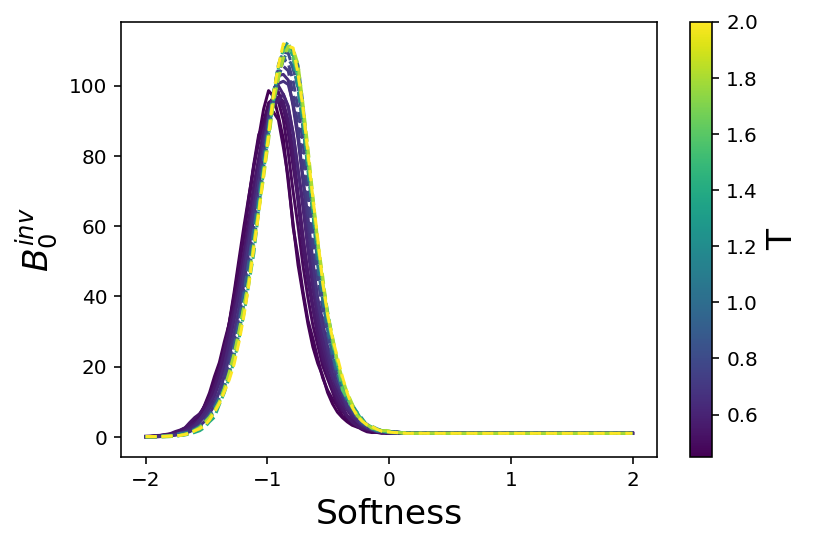

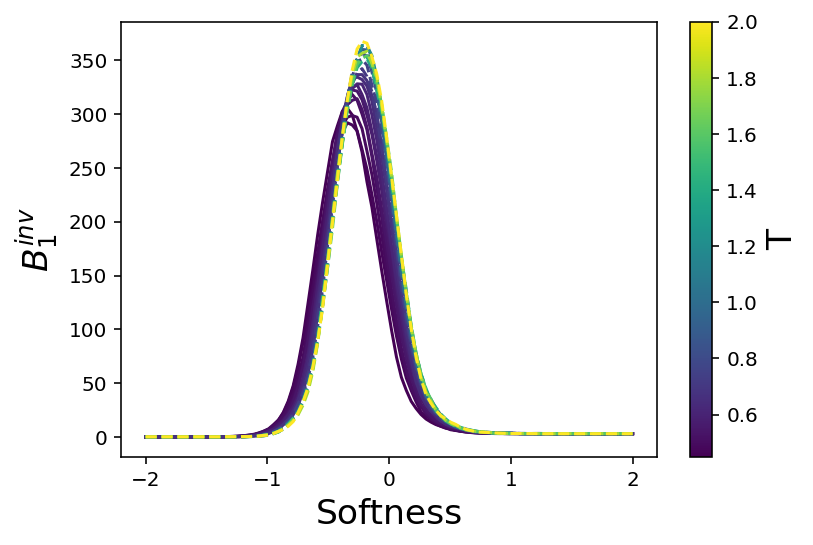

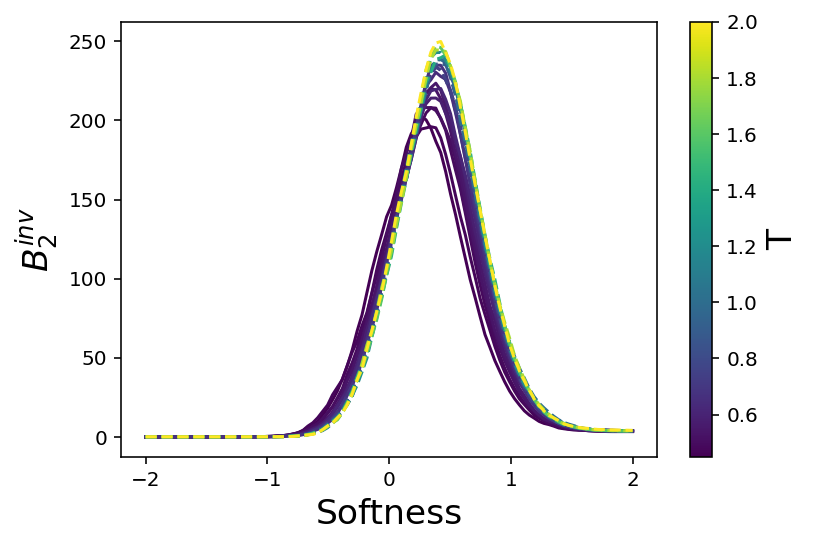

In [4]:
x = np.linspace(-2, 2, 100)
cmap = cm.viridis
norm = colors.Normalize(vmin=np.min(temps), vmax=np.max(temps))
dims = (0, 1, 2)
for dim in dims:
    plt.figure()
    for idx, (curve, temp) in enumerate(zip(betti_curves, temps)):
        m = "-"
        if temp >= 0.7:
            m = "--"
        plt.plot(x, curve[dim], m, label=f"{temp:.2f}", color=cmap(norm(temp)))
    plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), label="T")
    plt.ylabel(fr"$B^{{inv}}_{dim}$")
    plt.xlabel("Softness")
    # plt.savefig(f"betti-curve_dim-{dim}_bins-{n_bins}-inv.png", bbox_inches="tight", dpi=150)

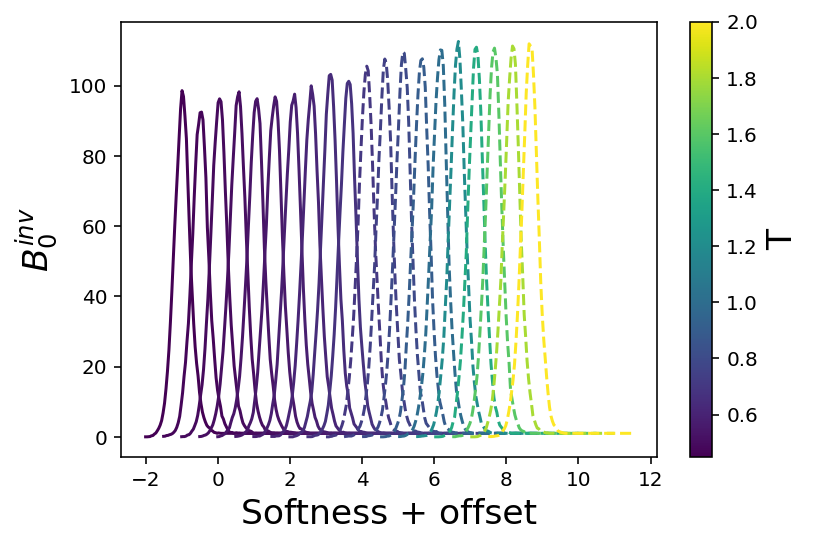

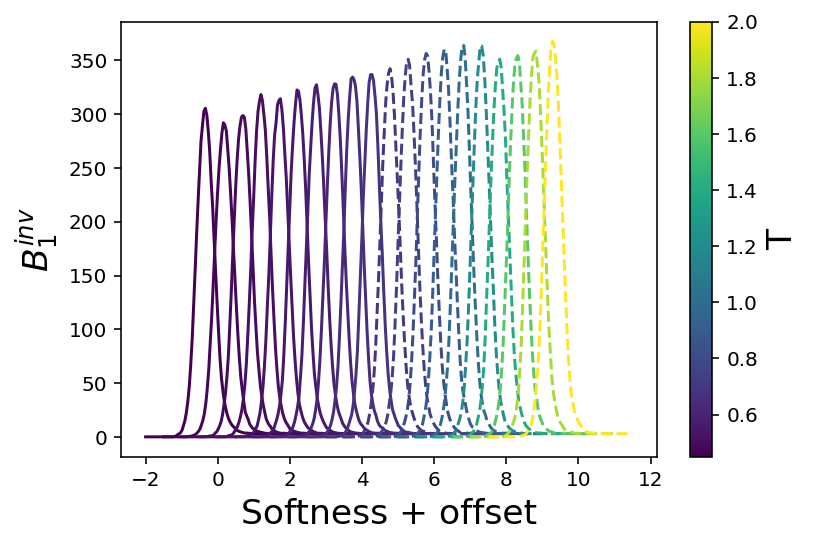

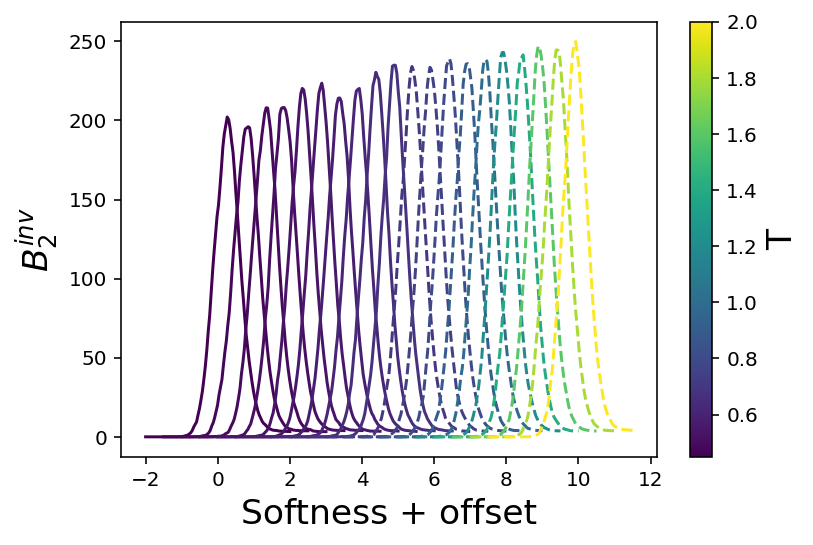

In [5]:
x = np.linspace(-2, 2, 100)
cmap = cm.viridis
norm = colors.Normalize(vmin=np.min(temps), vmax=np.max(temps))
for dim in dims:
    plt.figure()
    for idx, (curve, temp) in enumerate(zip(betti_curves, temps)):
        m = "-"
        if temp >= 0.7:
            m = "--"
        plt.plot(x + idx/2, curve[dim], m, label=f"{temp:.2f}", color=cmap(norm(temp)))
    plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), label="T")
    # plt.legend()
    plt.ylabel(fr"$B^{{inv}}_{dim}$")
    plt.xlabel("Softness + offset")
    # plt.savefig(f"betti-curve_dim-{dim}_bins-{n_bins}_offset-inv.png", bbox_inches="tight", dpi=150)

In [6]:
n_bins = 30

for delta, jobs_iter in project.find_jobs({"delta": 0.0}, {"_CRYSTAL": {"$exists": False}}).groupby("delta"):
    job_bettis = []
    for job in jobs_iter:
        betti_curves = []
        temps = []
        for run_dir in sorted(glob.glob(job.fn("short_runs/temp-*"))):
            temp = float(utils.extract_between(run_dir, "temp-", "/"))
            # if temp > 1.0:
            #     break
            temps.append(temp)
            print(temps[-1])
            run_dir = pathlib.Path(run_dir)
            # get softness df
            softness_df = pd.read_parquet(run_dir / "struct-descr.parquet")
            # get traj
            traj = gsd.hoomd.open(run_dir / "traj.gsd")

            betti_curve = compute_betti_curve(traj, softness_df, n_bins=n_bins, dims=(0,1,2), neg=True)
            betti_curves.append(betti_curve)
        # break
        job_bettis.append(betti_curves)
    betti_curves = np.mean(job_bettis, axis=0)

0.45
0.47
0.49
0.51
0.53
0.55
0.58
0.61
0.64
0.67
0.7
0.75
0.8
0.9
1.0
1.2
1.4
1.6
1.8
2.0
0.45
0.47
0.49
0.51
0.53
0.55
0.58
0.61
0.64
0.67
0.7
0.75
0.8
0.9
1.0
1.2
1.4
1.6
1.8
2.0
0.45
0.47
0.49
0.51
0.53
0.55
0.58
0.61
0.64
0.67
0.7
0.75
0.8
0.9
1.0
1.2
1.4
1.6
1.8
2.0


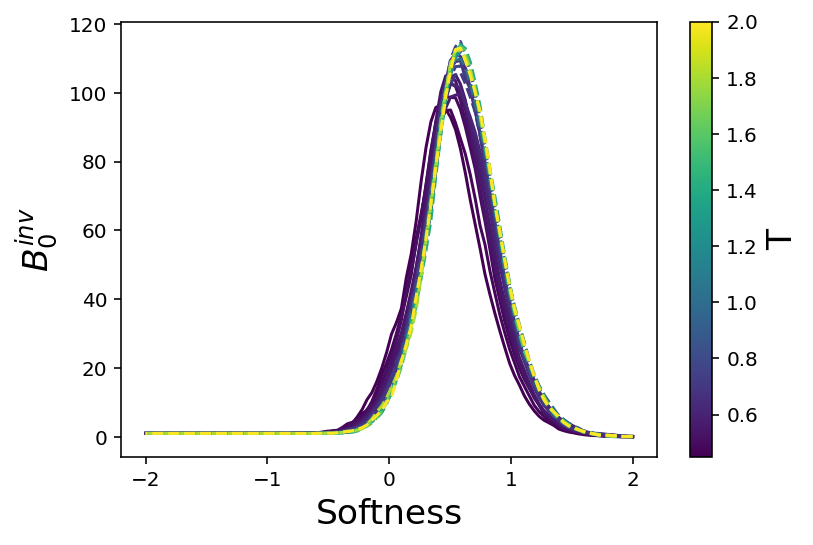

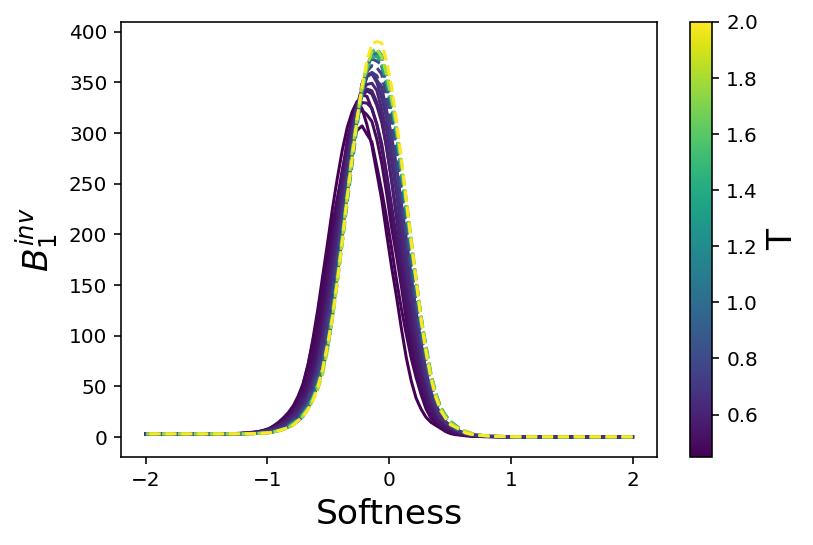

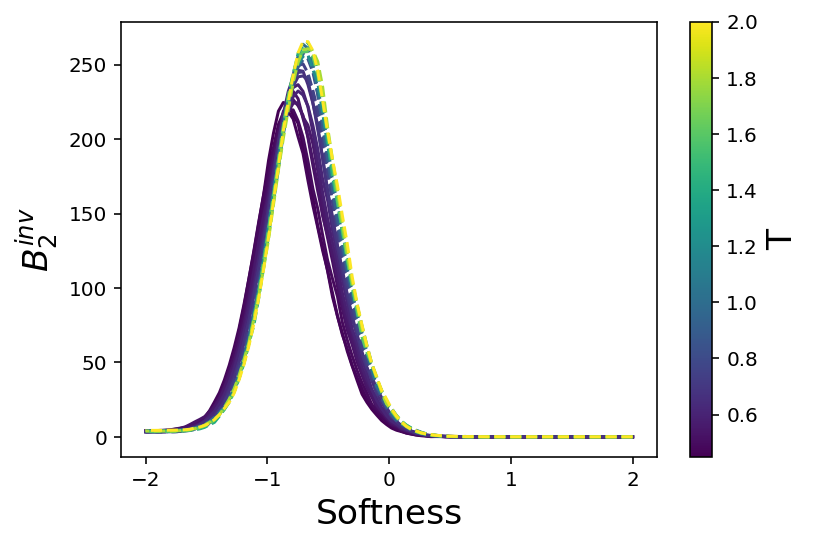

In [10]:
x = np.linspace(-2, 2, 100)
cmap = cm.viridis
norm = colors.Normalize(vmin=np.min(temps), vmax=np.max(temps))
dims = (0, 1, 2)
for dim in dims:
    plt.figure()
    for idx, (curve, temp) in enumerate(zip(betti_curves, temps)):
        m = "-"
        if temp >= 0.7:
            m = "--"
        plt.plot(-x, curve[dim], m, label=f"{temp:.2f}", color=cmap(norm(temp)))
    plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), label="T")
    plt.ylabel(fr"$B^{{inv}}_{dim}$")
    plt.xlabel("Softness")
    # plt.savefig(f"betti-curve_dim-{dim}_bins-{n_bins}-inv.png", bbox_inches="tight", dpi=150)

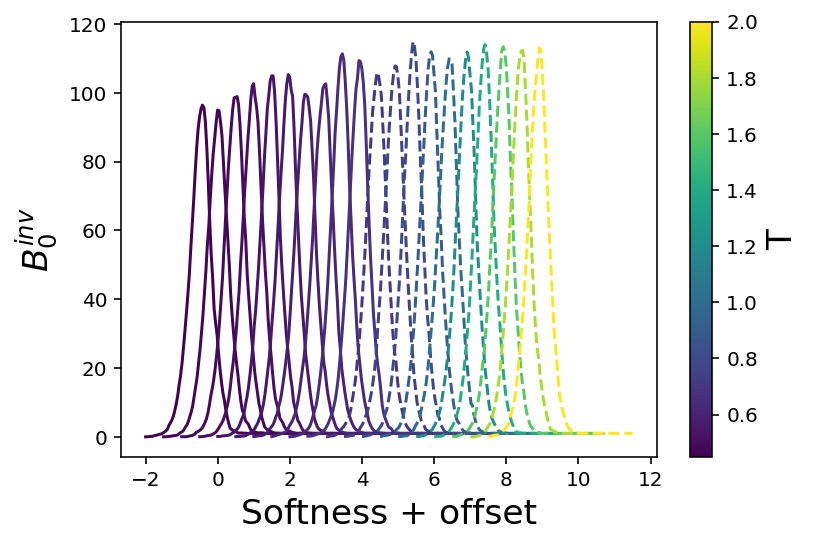

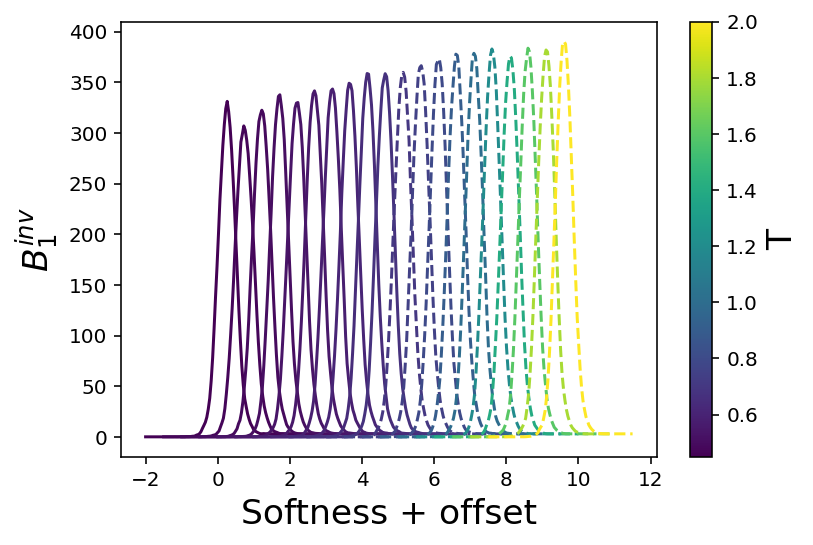

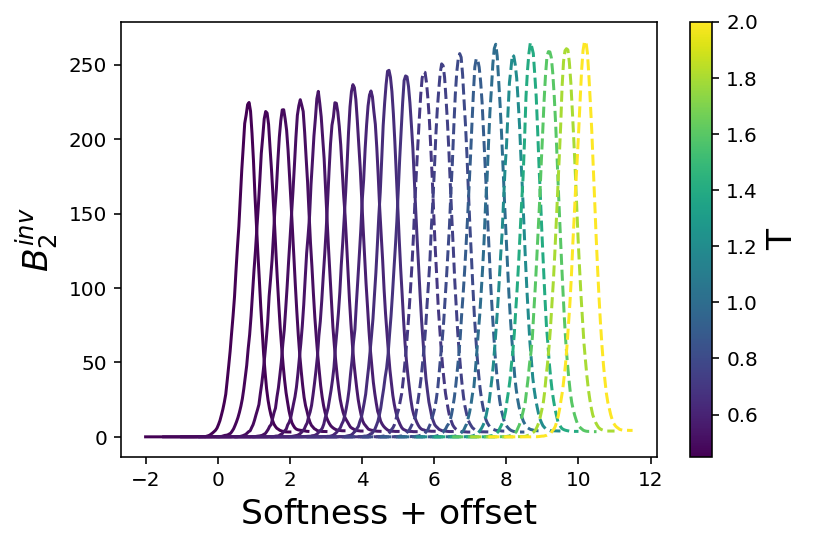

In [8]:
x = np.linspace(-2, 2, 100)
cmap = cm.viridis
norm = colors.Normalize(vmin=np.min(temps), vmax=np.max(temps))
for dim in dims:
    plt.figure()
    for idx, (curve, temp) in enumerate(zip(betti_curves, temps)):
        m = "-"
        if temp >= 0.7:
            m = "--"
        plt.plot(x + idx/2, curve[dim], m, label=f"{temp:.2f}", color=cmap(norm(temp)))
    plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), label="T")
    # plt.legend()
    plt.ylabel(fr"$B^{{inv}}_{dim}$")
    plt.xlabel("Softness + offset")
    # plt.savefig(f"betti-curve_dim-{dim}_bins-{n_bins}_offset-inv.png", bbox_inches="tight", dpi=150)

In [3]:
n_bins = 30
b_val = 0.5

for delta, jobs_iter in project.find_jobs({"delta": 0.0}, {"_CRYSTAL": {"$exists": False}}).groupby("delta"):
    job_bettis = []
    for job in jobs_iter:
        betti_curves = []
        temps = []
        for run_dir in sorted(glob.glob(job.fn("short_runs/temp-*"))):
            temp = float(utils.extract_between(run_dir, "temp-", "/"))
            # if temp > 1.0:
            #     break
            temps.append(temp)
            print(temps[-1])
            run_dir = pathlib.Path(run_dir)
            # get softness df
            softness_df = pd.read_parquet(run_dir / "struct-descr.parquet")
            # get traj
            traj = gsd.hoomd.open(run_dir / "traj.gsd")

            betti_curve = compute_betti_curve_w_bmask(traj, softness_df, n_bins=n_bins, dims=(0,1,2), neg=True, b_val=b_val)
            betti_curves.append(betti_curve)
        # break
        job_bettis.append(betti_curves)
    betti_curves = np.mean(job_bettis, axis=0)

0.45
0.47
0.49
0.51
0.53
0.55
0.58
0.61
0.64
0.67
0.7
0.75
0.8
0.9
1.0
1.2
1.4
1.6
1.8
2.0
0.45
0.47
0.49
0.51
0.53
0.55
0.58
0.61
0.64
0.67
0.7
0.75
0.8
0.9
1.0
1.2
1.4
1.6
1.8
2.0
0.45
0.47
0.49
0.51
0.53
0.55
0.58
0.61
0.64
0.67
0.7
0.75
0.8
0.9
1.0
1.2
1.4
1.6
1.8
2.0


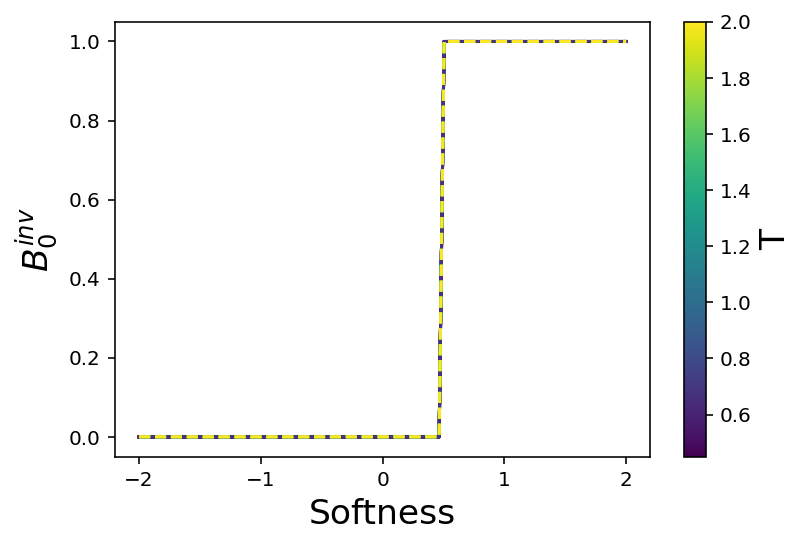

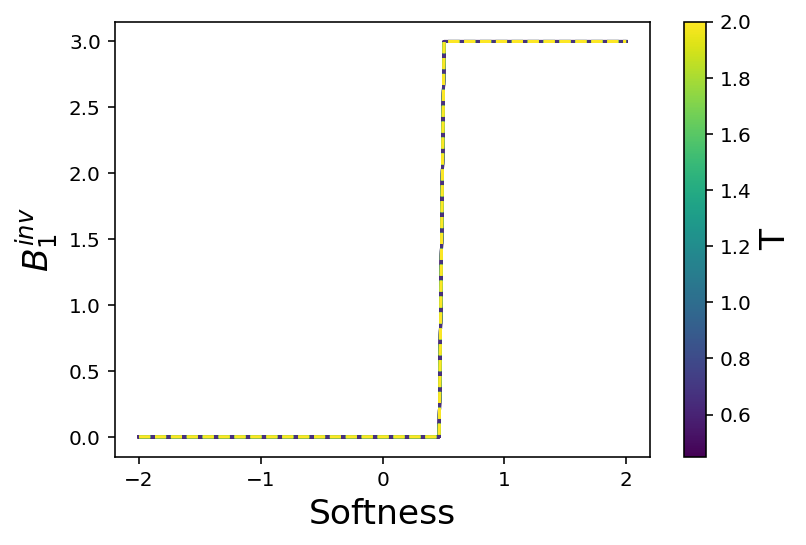

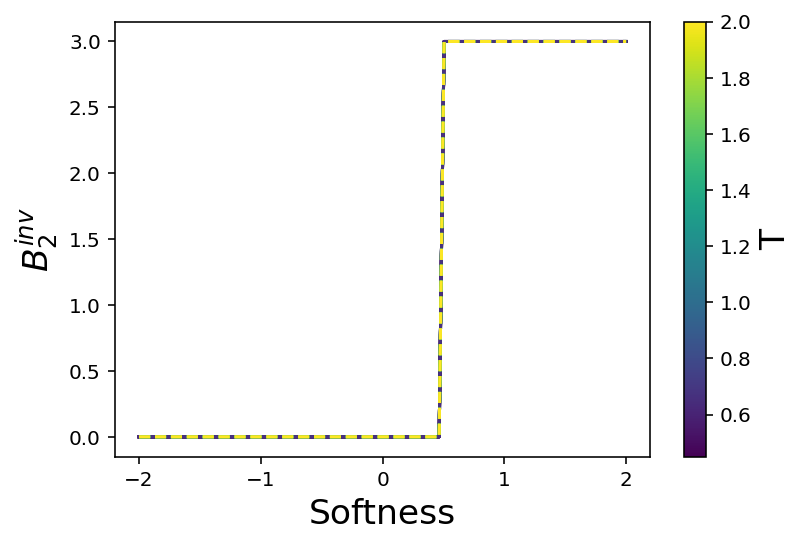

In [4]:
x = np.linspace(-2, 2, 100)
cmap = cm.viridis
norm = colors.Normalize(vmin=np.min(temps), vmax=np.max(temps))
dims = (0, 1, 2)
for dim in dims:
    plt.figure()
    for idx, (curve, temp) in enumerate(zip(betti_curves, temps)):
        m = "-"
        if temp >= 0.7:
            m = "--"
        plt.plot(x, curve[dim], m, label=f"{temp:.2f}", color=cmap(norm(temp)))
    plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), label="T")
    plt.ylabel(fr"$B^{{inv}}_{dim}$")
    plt.xlabel("Softness")
    # plt.savefig(f"betti-curve_dim-{dim}_bins-{n_bins}_bmask-{b_val}-inv.png", bbox_inches="tight", dpi=150)

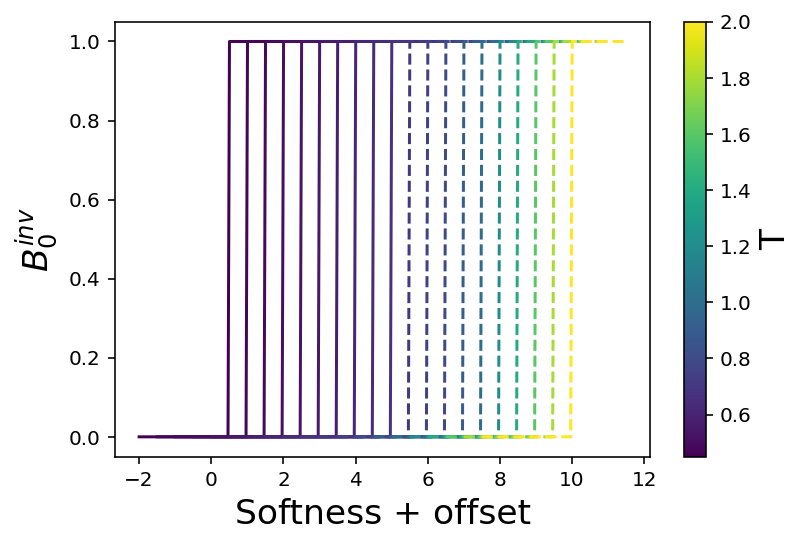

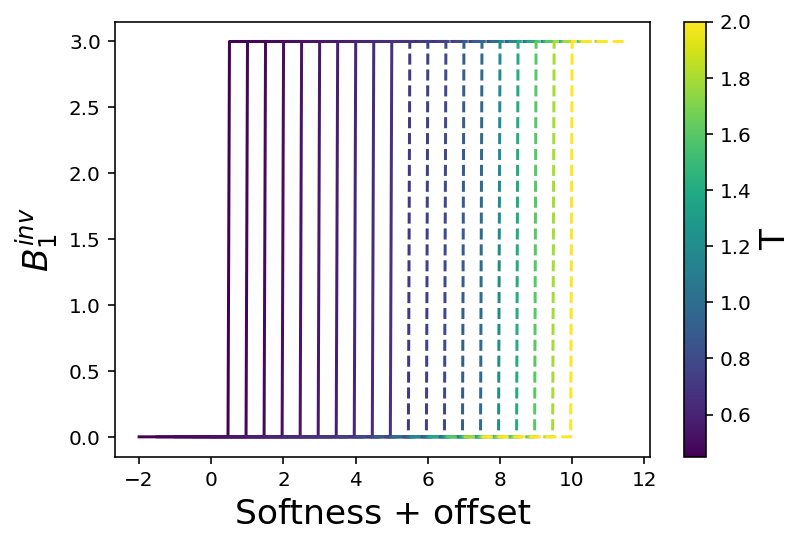

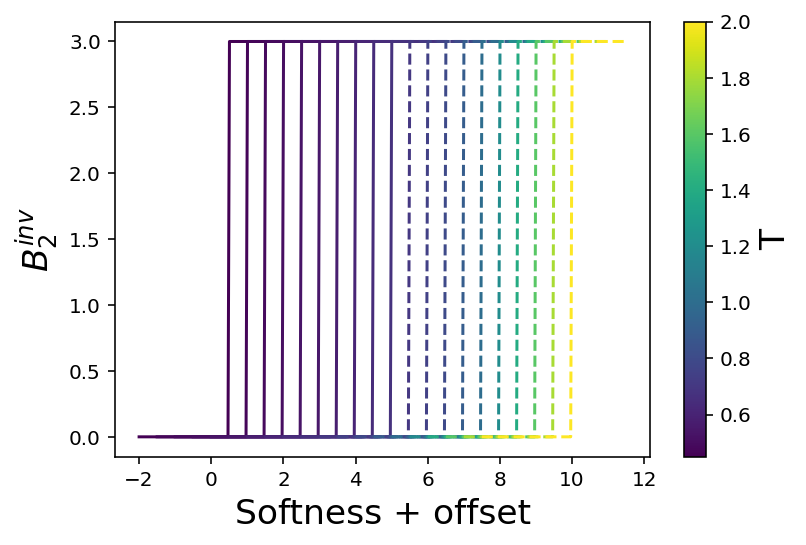

In [5]:
x = np.linspace(-2, 2, 100)
cmap = cm.viridis
norm = colors.Normalize(vmin=np.min(temps), vmax=np.max(temps))
for dim in dims:
    plt.figure()
    for idx, (curve, temp) in enumerate(zip(betti_curves, temps)):
        m = "-"
        if temp >= 0.7:
            m = "--"
        plt.plot(x + idx/2, curve[dim], m, label=f"{temp:.2f}", color=cmap(norm(temp)))
    plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), label="T")
    # plt.legend()
    plt.ylabel(fr"$B^{{inv}}_{dim}$")
    plt.xlabel("Softness + offset")
    # plt.savefig(f"betti-curve_dim-{dim}_bins-{n_bins}_bmask-{b_val}_offset-inv.png", bbox_inches="tight", dpi=150)

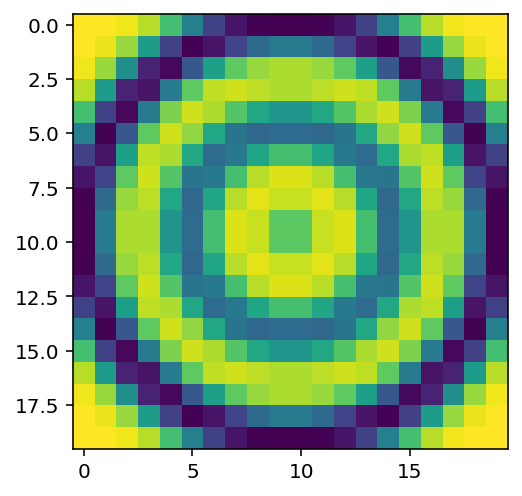

In [4]:
def gauss_2d(kernel_size, sigma=1, muu=0):
 
    # Initializing value of x,y as grid of kernel size
    # in the range of kernel size
 
    x, y = np.meshgrid(np.linspace(-1, 1, kernel_size),
                       np.linspace(-1, 1, kernel_size))
    dst = np.sqrt(x**2+y**2)
 
    # lower normal part of gaussian
    normal = 1/(2.0 * np.pi * sigma**2)
 
    # Calculating Gaussian filter
    gauss = np.exp(-((dst-muu)**2 / (2.0 * sigma**2))) * normal
    return gauss
 
 

N = 20
grid = 3 - ( gauss_2d(N, sigma=0.1) + 2.0 * gauss_2d(N, muu=0.5, sigma=0.1) + 3.0 * gauss_2d(N, muu=1.0, sigma=0.1) )
plt.imshow(grid)

In [1]:
from schmeud._schmeud import locality

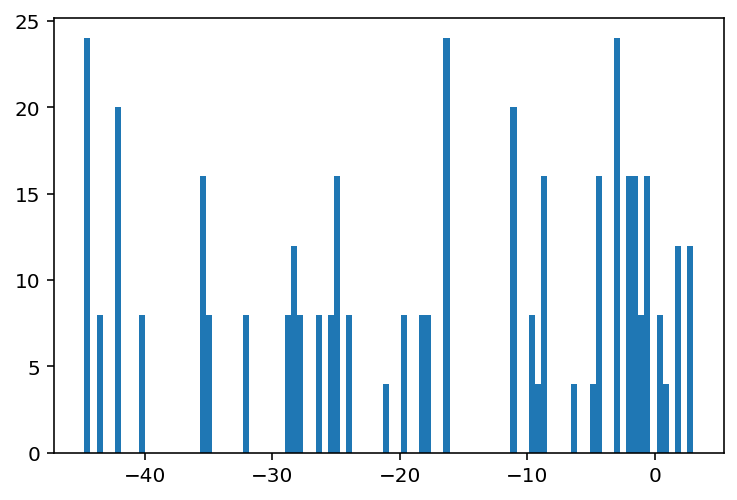

In [9]:
plt.hist(grid.flatten(), bins=100);

In [7]:
tree = locality.BlockTree(grid.astype(np.float32), False)

In [19]:
res = [np.array(a) for a in tree.mass_and_msd(np.linspace(-40.0, 10, 5, dtype=np.float32))]

In [20]:
res

[array([[-42.05787659, -35.47569656,   6.        ,   2.91666675],
        [-42.30847549, -35.47569656,   2.        ,   0.25      ],
        [-40.20558929, -35.47569656,   5.        ,   1.12      ],
        [-42.30847549, -35.47569656,   2.        ,   0.25      ],
        [-42.05787659, -35.47569656,   6.        ,   2.91666675],
        [-42.30847549, -35.47569656,   2.        ,   0.25      ],
        [-42.05787659, -35.47569656,   6.        ,   2.91666675],
        [-42.30847549, -35.47569656,   2.        ,   0.25      ],
        [-42.30847549, -35.47569656,   2.        ,   0.25      ],
        [-40.20558929, -35.47569656,   5.        ,   1.12      ],
        [-42.30847549, -35.47569656,   2.        ,   0.25      ],
        [-42.30847549, -35.47569656,   2.        ,   0.25      ],
        [-40.20558929, -35.47569656,   5.        ,   1.12000012],
        [-40.20558929, -35.47569656,   5.        ,   1.12      ],
        [-42.05787659, -35.47569656,   6.        ,   2.91666675],
        [-

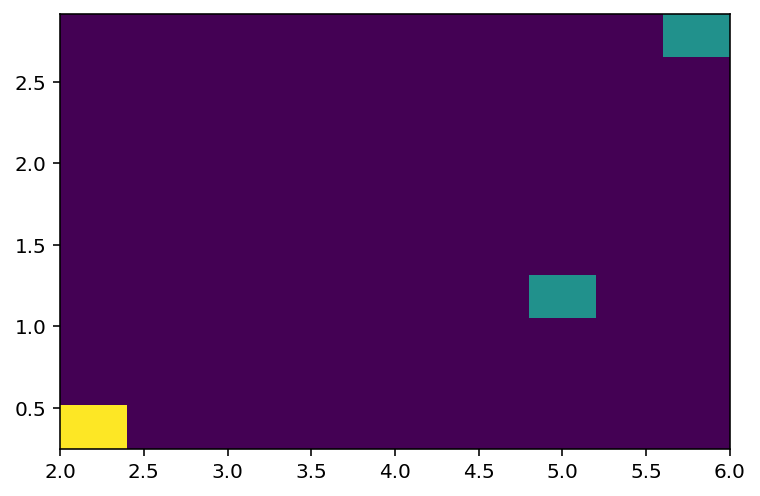

In [21]:
plt.hist2d(res[0][:,2], res[0][:,3]);

In [61]:
N = 3
grid = np.array([[1.0, 2.0, 1.5], [2.0, 3.0, 1.6], [1.5, 1.6, 1.7]])

In [37]:
complex = gudhi.CubicalComplex([N, N], grid.flatten())
complex.compute_persistence()

In [23]:
complex.betti_numbers()

[1, 0, 0]

In [29]:
complex.persistent_betti_numbers(0.0, 3.0)

[0, 0, 0]

In [41]:
complex.persistence_intervals_in_dimension(0)

array([[1.5, 1.6],
       [1.5, 2. ],
       [1. , inf]])

In [39]:
complex.cofaces_of_persistence_pairs()

[[array([[6, 7],
         [2, 1]]),
  array([[3, 4]])],
 [array([0])]]

In [34]:
gudhi.__version__

'3.7.1'

In [38]:
complex.persistence()

[(1, (2.0, 3.0)), (0, (1.0, inf)), (0, (1.5, 2.0)), (0, (1.5, 1.6))]

In [4]:
class BlockTree:
    
    def __init__(self):
        self.block_dict = {}  # potential optimization: only keep cells on boundary of blocks
        self.block_tree = {}
        self.tree_roots = set()
        self.tree_leafs = set()

class Node:

    def __init__(self, id):
        self.id = id
        self.parent = None
        self.children = []
        self.items = []
        self.filt = []

In [5]:
def build_block_tree(grid, N):
    
    def step(idx, v, xi, yi, zi, block_dict, block_tree, tree_roots, tree_leafs, N):
        jdx = copy.deepcopy(idx)
        # print(xi, yi, zi)
        # print("step")
        neigh = [[-1, 0, 0], [0, 1, 0], [0, -1, 0], [1, 0, 0], [0, 0, 1], [0, 0, -1]]
        found = []
        for n in neigh:
            # print(n)
            x = (xi + n[0])
            y = (yi + n[1])
            z = (zi + n[2])
            if x < 0 or x >= N or y < 0 or y >= N or z < 0 or z >= N:
                continue
            if (x, y, z) in block_dict:
                found.append(block_dict[(x, y, z)])
        
        # todo recurse up tree to find owning block
        new_found = []
        for f in found:
            node = block_tree[f]
            while node.parent is not None:
                # print("while")
                
                new_node = block_tree[node.parent]
                if new_node.id == node.id:
                    raise ValueError("loop")
                node = new_node
            new_found.append(node.id)
        # only use unique blocks
        found = np.unique(new_found)
        # if len(found) != 0:
        #     print(found)
        if len(found) == 0: # make new root
            # print("new")
            tree_roots.add(idx)
            tree_leafs.add(idx)
            node = Node(idx)
            node.items.append((xi, yi, zi))
            node.filt.append(v)
            block_tree[idx] = node
            
            block_dict[(xi, yi, zi)] = copy.deepcopy(idx)
            # print("making new node", block_dict[(xi, yi)])
            jdx = idx + 1
            # print(idx)
        if len(found) == 1: # add item to existing root
            f = found[0]
            block_tree[f].items.append((xi, yi, zi))
            block_tree[f].filt.append(v)
            block_dict[(xi, yi, zi)] = f
        else: # merge blocks into a new block
            tree_roots.add(idx)
            node = Node(idx)
            node.items.append((xi, yi, zi))
            node.filt.append(v)
            block_tree[idx] = node
            block_dict[(xi, yi, zi)] = copy.deepcopy(idx)

            for f in found: # merge blocks
                # print(f)
                child_node = block_tree[f]
                child_node.parent = idx
                node.children.append(f)
                # print(f)
                tree_roots.remove(f)
                
            jdx = idx + 1
        # print(block_dict)
        return jdx

    tree = BlockTree()

    # test_grid = np.nan_to_num(test_grid, nan=0.0)

    indices = np.argsort(grid, axis=None)
    x, y, z = np.unravel_index(indices, grid.shape)

    idx = 0
    for v, i, xi, yi, zi in zip(grid.ravel()[indices], indices, x, y, z):
        idx = step(idx, v, xi, yi, zi, tree.block_dict, tree.block_tree, tree.tree_roots, tree.tree_leafs, N)
    return tree

In [6]:
def compute_mass_and_msd(tree):
    nodes = tree.tree_roots

    output = []

    while len(nodes) > 0:
        new_nodes = []
        for node_id in nodes:
            data = []
            children = []
            node_children = tree.block_tree[node_id].children
            node = tree.block_tree[node_id]
            children.extend(node_children)
            while len(children) > 0:
                new_children = []
                for child in children:
                    child_node = tree.block_tree[child]
                    data.extend(child_node.items)
                    new_children.extend(child_node.children)
                children = new_children
            data.extend(tree.block_tree[node_id].items)
            data = np.array(data)
            if node.parent is None:
                death = np.inf
            else:
                death = tree.block_tree[node.parent].filt[0]

            for v in tree.block_tree[node_id].filt[::-1]:
                if v == death:
                    data = data[:-1]
                    continue
                M = len(data)
                x_com = np.mean(data, axis=0)
                msd = np.sum(np.square(data - x_com))/M
                data = data[:-1]
                output.append((v, death, M, msd))
                death = v
            new_nodes.extend(node_children)
        nodes = new_nodes
    return output

In [7]:
def process_filtration(filtration_data, filtration):
    
    filtration_data = sorted(filtration_data, key=lambda x: x[1])

    result_scan = []
    for val in filtration:
        output_arr = np.array(filtration_data)

        start = np.searchsorted(output_arr[:,1], val)
        # print(start)
        output_slice = output_arr[start:]
        indices = np.argsort(output_slice[:, 0])
        # print(indices)
        idx = 0
        result = []
        while output_slice[indices[idx], 0] < val:
            # print(output_slice[indices[idx]])
            result.append(output_slice[indices[idx]])
            idx += 1
        result = np.array(result)
        result_scan.append(result)
    return result_scan

In [4]:
def plot_mass_and_msd(scan, filtration, axs=None):
    cmap = cm.viridis
    norm = colors.Normalize(vmin=np.min(filtration), vmax=np.max(filtration))

    ax_idx = None
    if axs is None:
        fig, ax = plt.subplots()
    else:
        if not isinstance(axs, plt.Axes):
            ax_idx = 0
        else:
            plt.sca(axs)
        

    for val, res in list(zip(filtration, scan))[::-1]:
        if ax_idx is not None:
            plt.sca(axs[ax_idx])
            ax_idx += 1
        res = np.array(res)
        if len(res) == 0:
            continue
        # plt.scatter(res[:, 2], res[:, 3], color=cmap(norm(val)), s=40)
        plt.hist2d(res[:, 2], res[:, 3], bins=100, norm=mpl.colors.LogNorm(), cmap=cmap)
        # plt.scatter([val]*len(res), res[:, 3], color=cmap(norm(val)), s=40)
    # plt.yscale('log')
    plt.xscale('log')
    # plt.xlabel("Mass")
    plt.ylabel(r"$\langle \left( x - x_{com} \right)^2 \rangle$")
    plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), label="Softness level set")

In [5]:
def process_grid_old(grid, N, axs=None):
    vmin = np.min(grid)
    vmax = np.max(grid)

    filtration = np.linspace(vmin, vmax, 10)

    tree = build_block_tree(grid, N)
    filtration_data = compute_mass_and_msd(tree)
    scan = process_filtration(filtration_data, filtration)
    plot_mass_and_msd(scan, filtration, ax=ax)

def process_grid(grid, filt, periodic=True, axs=None):

    tree = schmeud_locality.BlockTree(grid.astype(np.float32), periodic)

    output = tree.mass_and_msd(filt)
    # for i in range(len(output)):
    #     print(len(output[i]))
    plot_mass_and_msd(output, filt, axs=axs)

def grid_process_step1(grid, filt, periodic=True):

    tree = schmeud_locality.BlockTree(grid.astype(np.float32), periodic)

    output = tree.mass_and_msd(filt)
    return output

def plot_mass_and_msd_multi(scan_data, filtration, axs=None):
    cmap = cm.viridis
    norm = colors.Normalize(vmin=np.min(filtration), vmax=np.max(filtration))

    bins = np.geomspace(1e-1, 1e5, 20)

    ax_idx = None
    if axs is None:
        fig, ax = plt.subplots()
    else:
        if not isinstance(axs, plt.Axes):
            ax_idx = 0
        else:
            plt.sca(axs)
        

    for idx, val in enumerate(filtration):
        if ax_idx is not None:
            plt.sca(axs[ax_idx])
            ax_idx += 1
        res = []
        for data in scan_data:
            if len(data[idx]) == 0:
                continue
            res.append(np.array(data[idx]))
        if len(res) == 0:
            continue
        res = np.concatenate(res)
        # print(res.shape)
        # plt.scatter(res[:, 2], res[:, 3], color=cmap(norm(val)), s=40)
        # plt.hist2d(res[:, 2], res[:, 3], norm=mpl.colors.LogNorm(), cmap=cmap, bins=[bins, bins])
        sns.regplot(x=res[:, 2], y=res[:, 3], scatter_kws={"s": 10}, color=cmap(norm(val)), scatter=False, fit_reg=False, ax=plt.gca())
        # plt.scatter([val]*len(res), res[:, 3], color=cmap(norm(val)), s=40)
    # plt.yscale('log')
    # plt.xscale('log')
    # plt.xlabel("Mass")
    # plt.ylabel(r"$\langle \left( x - x_{com} \right)^2 \rangle$")
    # plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), label="Softness level set")

def grid_process_step2(scan_data, filt, axs=None):
    plot_mass_and_msd_multi(scan_data, filt, axs=axs)

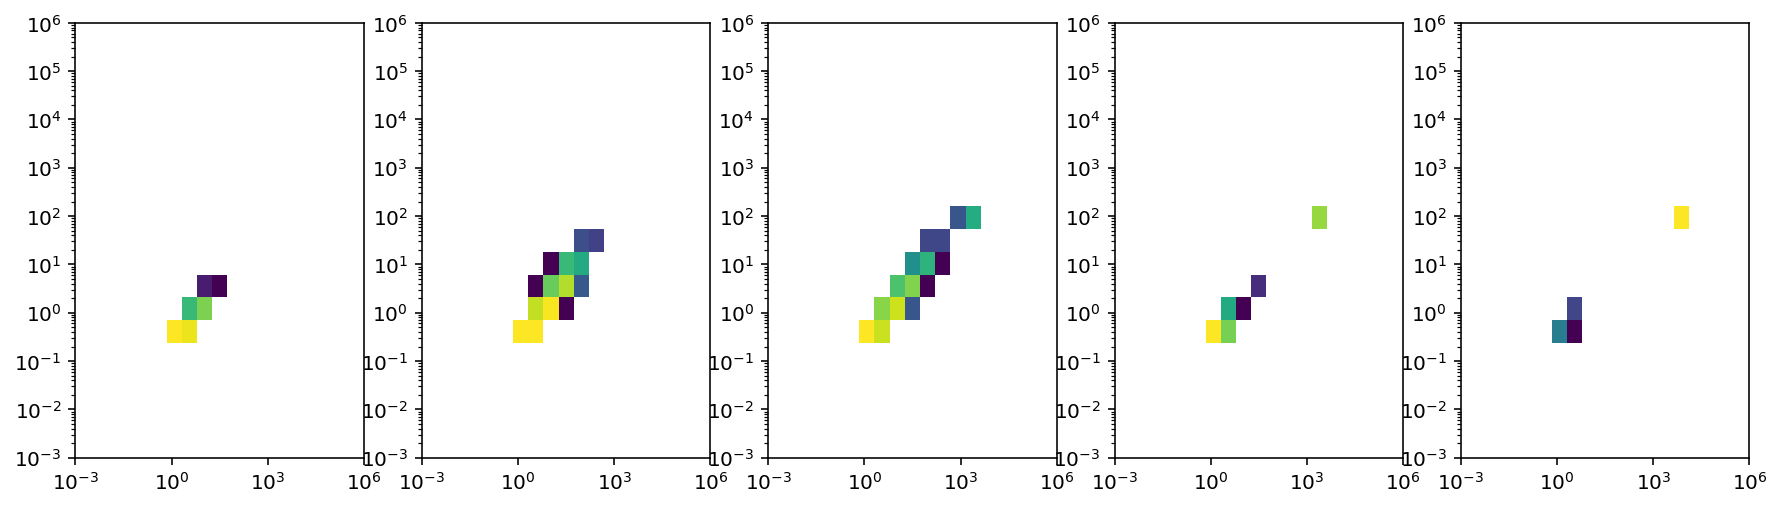

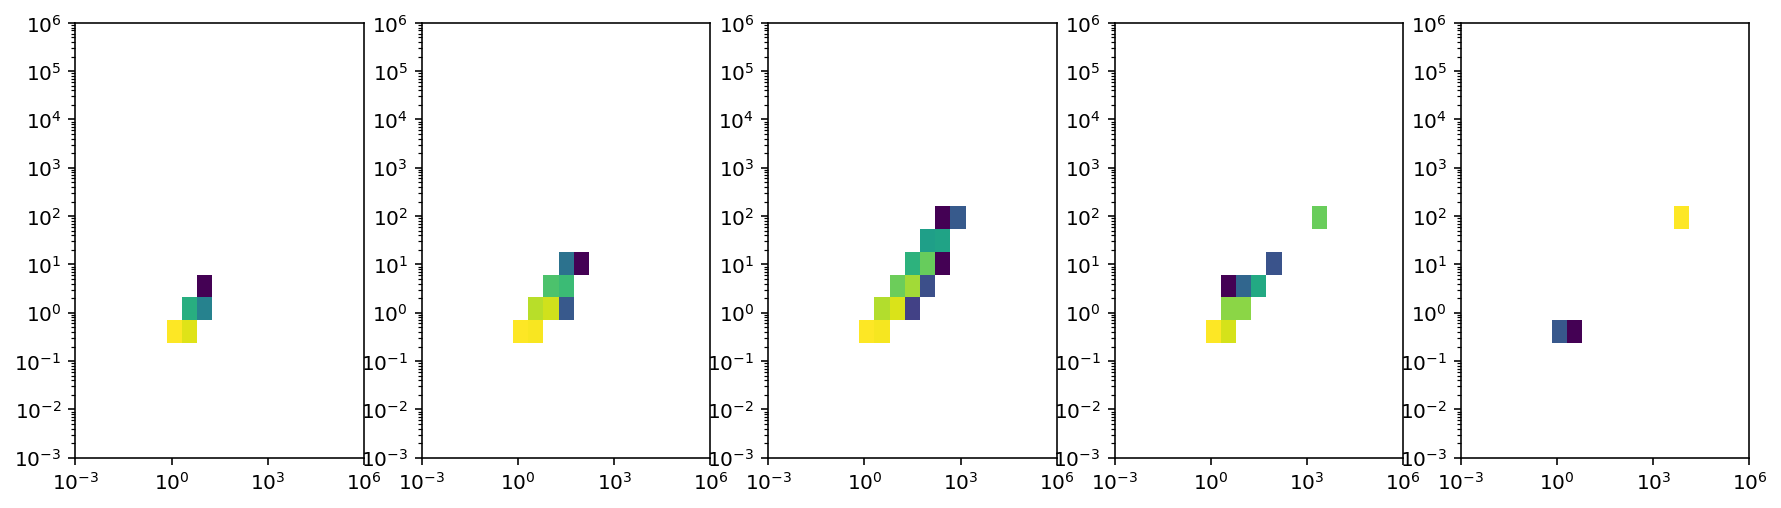

In [23]:
n_bins = 20
N = n_bins

output = defaultdict(list)

for delta, jobs_iter in project.find_jobs({"delta": 0.0}, {"_CRYSTAL": {"$exists": False}}).groupby("delta"):
    job_bettis = []
    for job in jobs_iter:
        betti_curves = []
        temps = []
        for run_dir in sorted(glob.glob(job.fn("short_runs/temp-*"))):
            temp = float(utils.extract_between(run_dir, "temp-", "/"))
            # print(temp)
            if temp not in [0.47, 0.7]:
                continue
            temps.append(temp)
            # print(temps[-1])
            run_dir = pathlib.Path(run_dir)
            # get softness dfb
            softness_df = pd.read_parquet(run_dir / "struct-descr.parquet")
            # get traj
            traj = gsd.hoomd.open(run_dir / "traj.gsd")

            for frame in softness_df["frame"].unique():
                grid = get_grid(traj, frame, softness_df, n_bins=n_bins, dims=(0,1,2))
                assert(not np.isnan(grid).any())
                
                # print(np.min(grid), np.max(grid))
                # process_grid(grid, np.linspace(-1.0, 0.0, 5, dtype=np.float32), axs=axs)
                output[temp].append(grid_process_step1(grid, np.linspace(-1.0, 0.0, 5, dtype=np.float32), periodic=False))
            # ax.set_ylim(1e-1, 2e2)
            # ax.set_xlim(1, 1e4)
            # # break
            # ax.set_title(f"T={temp:.2f}")
        
    break


for k, v in output.items():
    fig, axs = plt.subplots(1, 5, figsize=(15, 4))
    grid_process_step2(v, np.linspace(-1.0, 0.0, 5, dtype=np.float32), axs=axs)
    for ax in axs:
        ax.set_xscale('log')
        ax.set_yscale('log')

In [11]:
import seaborn as sns

def plot_mass_and_msd_multi(scan_data, filtration, axs=None):
    cmap = cm.viridis
    norm = colors.Normalize(vmin=np.min(filtration), vmax=np.max(filtration))

    bins = np.geomspace(1e-1, 1e5, 20)

    ax_idx = None
    if axs is None:
        fig, ax = plt.subplots()
    else:
        if not isinstance(axs, plt.Axes):
            ax_idx = 0
        else:
            plt.sca(axs)
        

    for idx, val in enumerate(filtration):
        if ax_idx is not None:
            plt.sca(axs[ax_idx])
            ax_idx += 1
        res = []
        for data in scan_data:
            if len(data[idx]) == 0:
                continue
            res.append(np.array(data[idx]))
        if len(res) == 0:
            continue
        res = np.concatenate(res)
        # print(res.shape)
        # plt.scatter(res[:, 2], res[:, 3], color=cmap(norm(val)), s=40)
        # plt.hist2d(res[:, 2], res[:, 3], norm=mpl.colors.LogNorm(), cmap=cmap, bins=[bins, bins])
        sns.regplot(x=res[:, 2], y=res[:, 3], color=cmap(norm(val)), scatter=True, fit_reg=False, ax=plt.gca(), x_bins=bins)
        # plt.scatter([val]*len(res), res[:, 3], color=cmap(norm(val)), s=40)
    # plt.yscale('log')
    # plt.xscale('log')
    # plt.xlabel("Mass")
    # plt.ylabel(r"$\langle \left( x - x_{com} \right)^2 \rangle$")
    # plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), label="Softness level set")

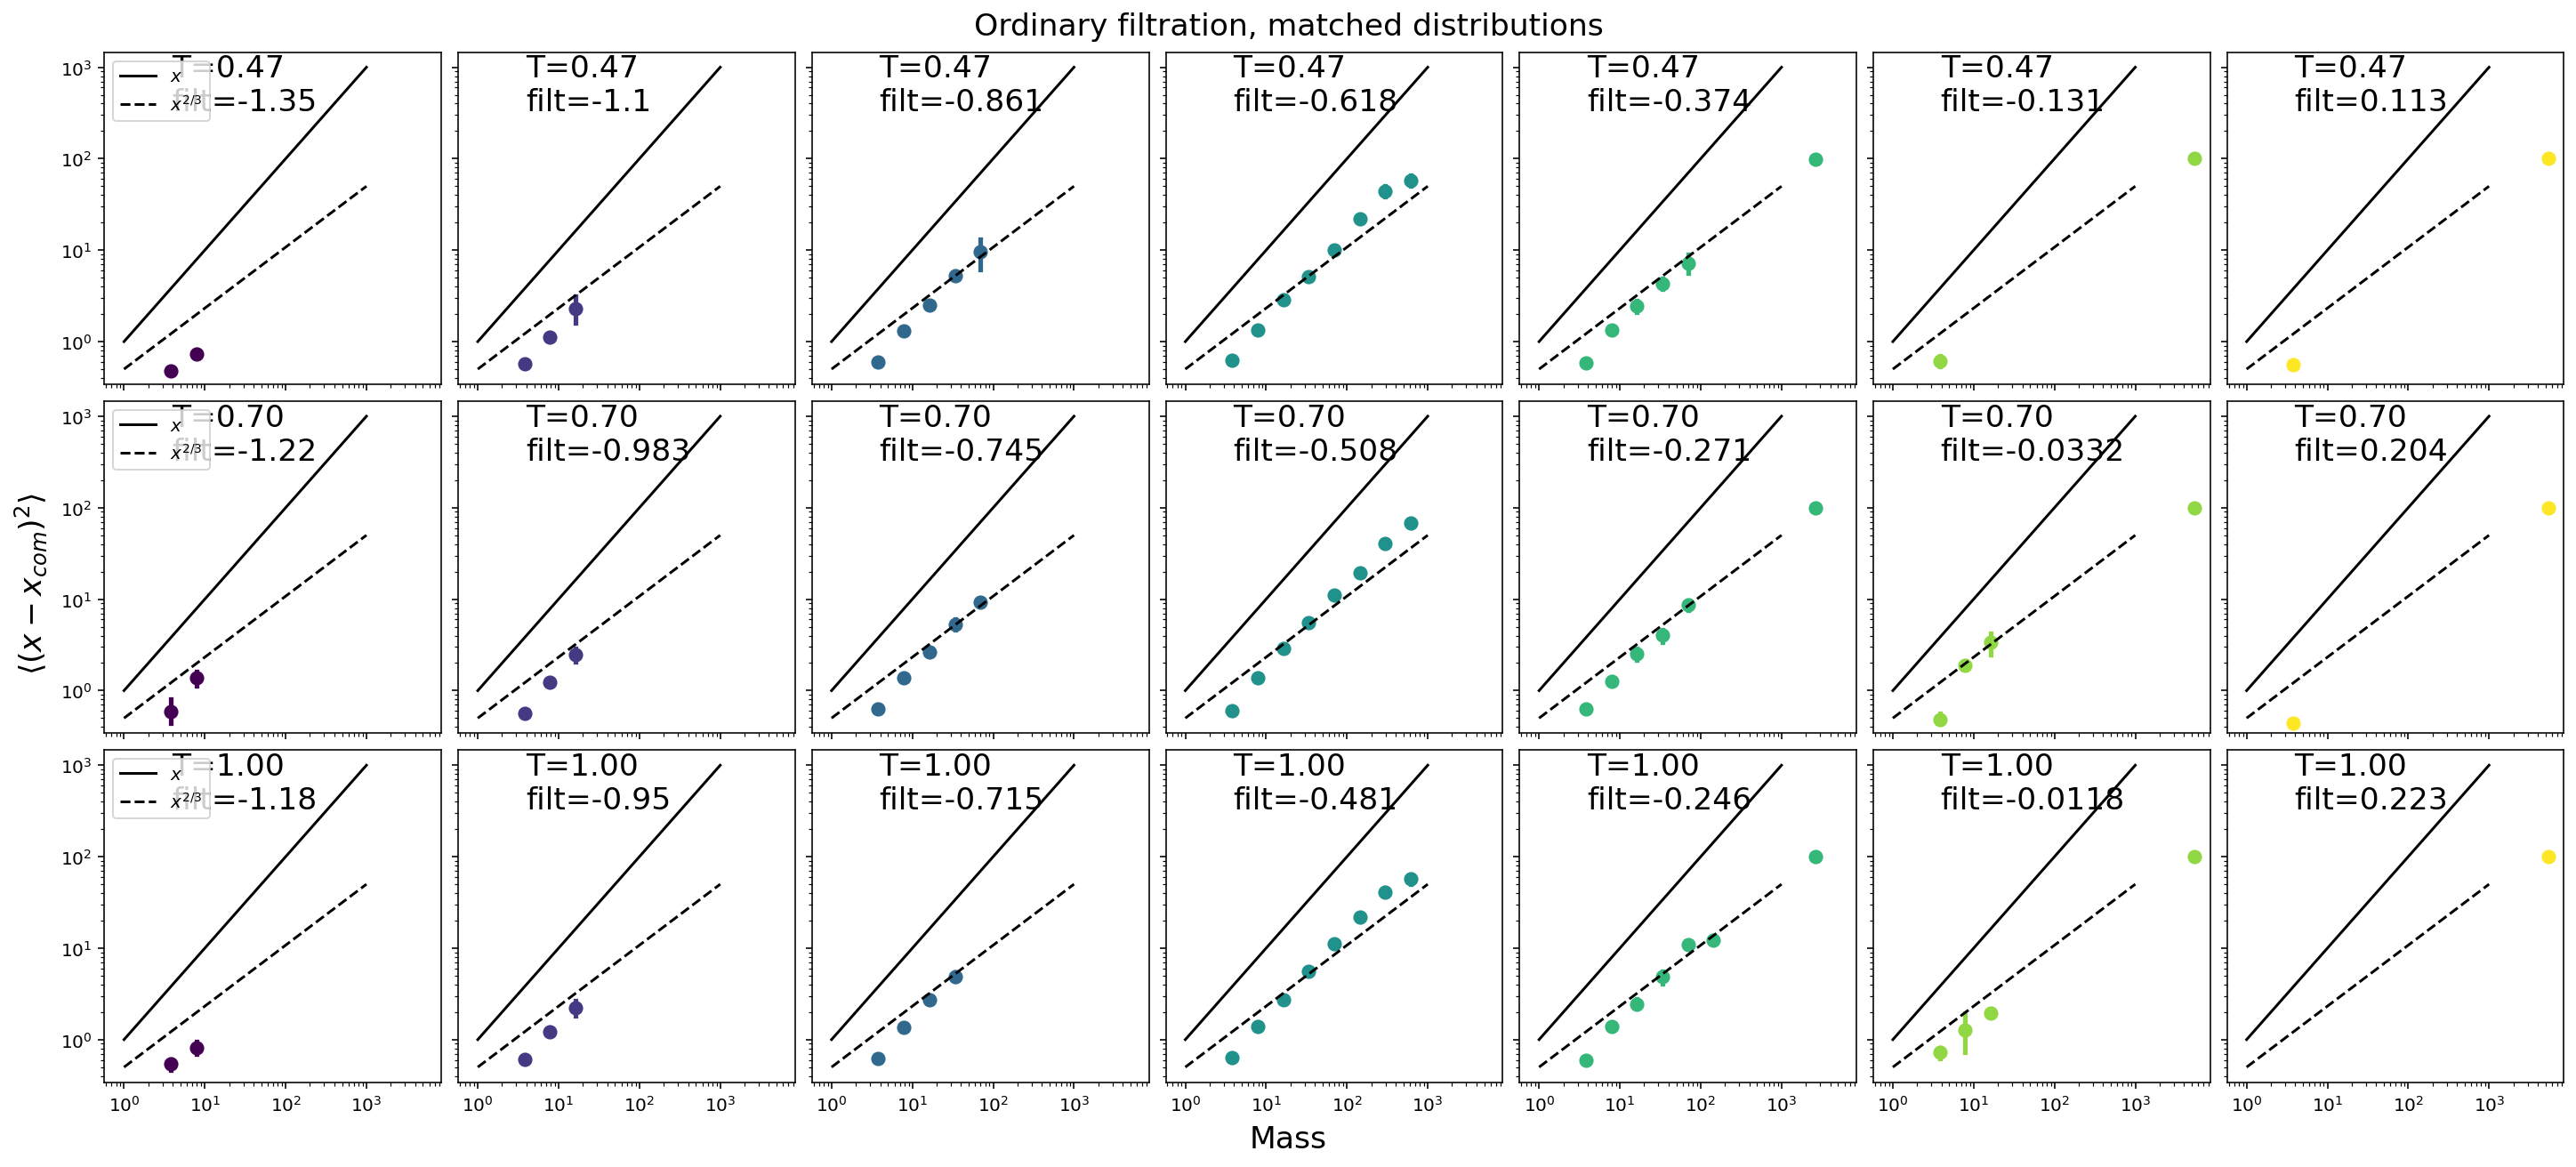

In [12]:
n_bins = 20
N = n_bins

output = defaultdict(list)

for delta, jobs_iter in project.find_jobs({"delta": 0.0}, {"_CRYSTAL": {"$exists": False}}).groupby("delta"):
    job_bettis = []
    for job in jobs_iter:
        betti_curves = []
        temps = []
        for run_dir in sorted(glob.glob(job.fn("short_runs/temp-*"))):
            temp = float(utils.extract_between(run_dir, "temp-", "/"))
            # print(temp)
            # print(temp)
            if temp not in [0.47, 0.7, 1.0]:
                continue
            temps.append(temp)
            # print(temps[-1])
            run_dir = pathlib.Path(run_dir)
            # get softness dfb
            softness_df = pd.read_parquet(run_dir / "struct-descr.parquet")
            # get traj
            traj = gsd.hoomd.open(run_dir / "traj.gsd")

            for frame in softness_df["frame"].unique():
                grid = get_grid(traj, frame, softness_df, n_bins=n_bins, dims=(0,1,2))
                assert(not np.isnan(grid).any())
                output[temp].append(grid)
                
                # print(np.min(grid), np.max(grid))
                # process_grid(grid, np.linspace(-1.0, 0.0, 5, dtype=np.float32), axs=axs)


        
    break

fig, all_axs = plt.subplots(3, 7, figsize=(20, 9), layout='constrained', sharex=True, sharey=True)
# for ax in all_axs.ravel():
#     ax.set_aspect('equal', 'box')
idx = 0
for temp, grids in output.items():
    mean = np.mean(grids)
    std = np.std(grids)
    axs = all_axs[idx]

    filt = np.linspace(mean - std*3, mean + std*1, 7, dtype=np.float32)

    out = []
    for grid in grids:
        out.append(grid_process_step1(grid, filt, periodic=False))
    # print(out)

    x = np.geomspace(1e0, 1e3, 100)
    y = x
    y_root = 0.5*np.power(x, 2/3)
    
    
    grid_process_step2(out, filt, axs=axs)
    for jdx, ax in enumerate(axs):
        ax.plot(x, y, color="black", linestyle="-", label=r"$x$")
        ax.plot(x, y_root, color="black", linestyle="--", label=r"$x^{2/3}$")
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.text(0.2, 0.9, f"T={temp:.2f}\nfilt={filt[jdx]:.3}", transform=ax.transAxes, horizontalalignment='left', verticalalignment='center', size="xx-large")
        
    idx += 1
    axs[0].legend()

fig.supxlabel("Mass", size="xx-large")
fig.supylabel(r"$\langle \left( x - x_{com} \right)^2 \rangle$", size="xx-large");
fig.suptitle("Ordinary filtration, matched distributions", size="xx-large");
fig.savefig("/home/ian/Pictures/distributions1.png", dpi=150);

In [7]:
tree = schmeud_locality.BlockTree(grid.astype(np.float32), True)

In [12]:
for f, a in zip(filt, tree.get_sites(filt)):
    for j in a:
        for k in j:
            for l in k:
                if l < 0 or l >= 20:
                    print(f, j)
                    break

-0.7152641 [(17.0, 8.0, 17.0), (18.0, 7.0, 16.0), (17.0, 8.0, 18.0), (17.0, 8.0, 19.0), (17.0, 9.0, 19.0), (17.0, 9.0, 20.0), (19.0, 7.0, 17.0), (19.0, 5.0, 17.0), (19.0, 8.0, 17.0), (17.0, 7.0, 17.0), (18.0, 7.0, 18.0), (18.0, 8.0, 17.0), (19.0, 8.0, 16.0), (18.0, 6.0, 17.0), (17.0, 7.0, 16.0), (18.0, 8.0, 16.0), (19.0, 6.0, 18.0), (19.0, 7.0, 18.0), (19.0, 6.0, 17.0), (18.0, 7.0, 17.0)]
-0.7152641 [(17.0, 19.0, 5.0), (18.0, 19.0, 4.0), (18.0, -20.0, 5.0), (17.0, 20.0, 5.0), (17.0, 19.0, 4.0)]
-0.7152641 [(17.0, 19.0, 5.0), (18.0, 19.0, 4.0), (18.0, -20.0, 5.0), (17.0, 20.0, 5.0), (17.0, 19.0, 4.0)]
-0.7152641 [(19.0, 3.0, 10.0), (19.0, 4.0, 10.0), (20.0, 3.0, 9.0), (19.0, 3.0, 9.0), (20.0, 3.0, 10.0), (20.0, 2.0, 9.0)]
-0.7152641 [(19.0, 3.0, 10.0), (19.0, 4.0, 10.0), (20.0, 3.0, 9.0), (19.0, 3.0, 9.0), (20.0, 3.0, 10.0), (20.0, 2.0, 9.0)]
-0.7152641 [(19.0, 3.0, 10.0), (19.0, 4.0, 10.0), (20.0, 3.0, 9.0), (19.0, 3.0, 9.0), (20.0, 3.0, 10.0), (20.0, 2.0, 9.0)]
-0.7152641 [(17.0, 0.0,

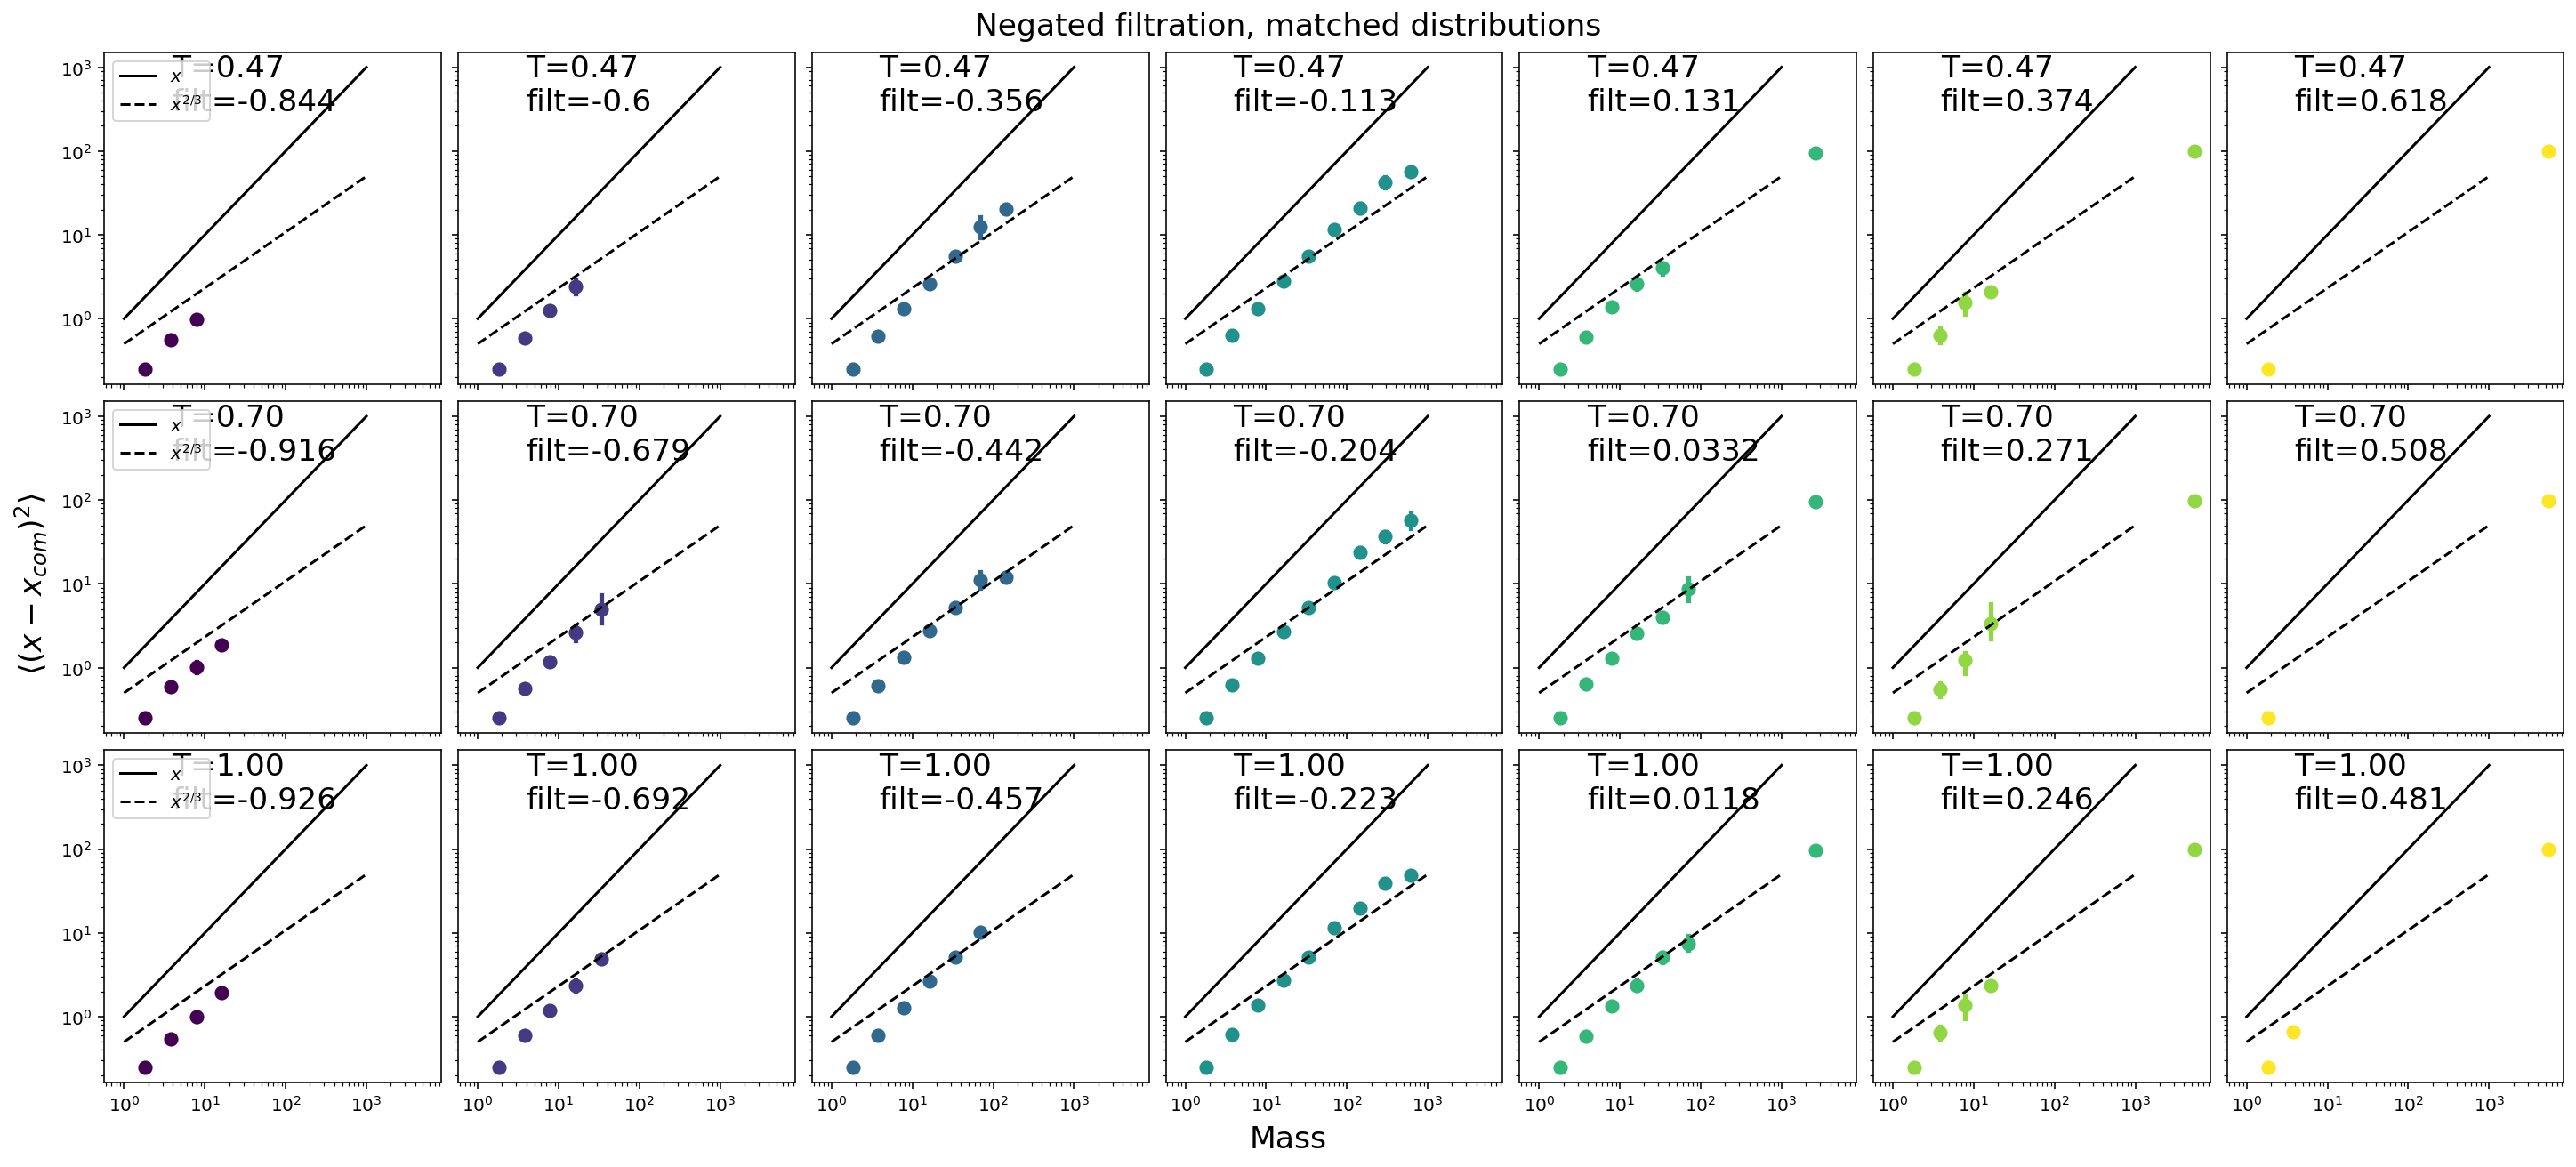

In [13]:
n_bins = 20
N = n_bins

output = defaultdict(list)

for delta, jobs_iter in project.find_jobs({"delta": 0.0}, {"_CRYSTAL": {"$exists": False}}).groupby("delta"):
    job_bettis = []
    for job in jobs_iter:
        betti_curves = []
        temps = []
        for run_dir in sorted(glob.glob(job.fn("short_runs/temp-*"))):
            temp = float(utils.extract_between(run_dir, "temp-", "/"))
            # print(temp)
            if temp not in [0.47, 0.7, 1.0]:
                continue
            temps.append(temp)
            # print(temps[-1])
            run_dir = pathlib.Path(run_dir)
            # get softness dfb
            softness_df = pd.read_parquet(run_dir / "struct-descr.parquet")
            # get traj
            traj = gsd.hoomd.open(run_dir / "traj.gsd")

            for frame in softness_df["frame"].unique():
                grid = get_grid(traj, frame, softness_df, n_bins=n_bins, dims=(0,1,2), neg=True)
                assert(not np.isnan(grid).any())
                output[temp].append(grid)
                
                # print(np.min(grid), np.max(grid))
                # process_grid(grid, np.linspace(-1.0, 0.0, 5, dtype=np.float32), axs=axs)


        
    break


fig, all_axs = plt.subplots(3, 7, figsize=(20, 9), layout='constrained', sharex=True, sharey=True)
# for ax in all_axs.ravel():
#     ax.set_aspect('equal', 'box')
idx = 0
for temp, grids in output.items():
    mean = np.mean(grids)
    std = np.std(grids)
    axs = all_axs[idx]

    filt = np.linspace(mean - std*3, mean + std*1, 7, dtype=np.float32)

    out = []
    for grid in grids:
        out.append(grid_process_step1(grid, filt, periodic=False))
    # print(out)

    x = np.geomspace(1e0, 1e3, 100)
    y = x
    y_root = 0.5*np.power(x, 2/3)
    
    
    grid_process_step2(out, filt, axs=axs)
    for jdx, ax in enumerate(axs):
        ax.plot(x, y, color="black", linestyle="-", label=r"$x$")
        ax.plot(x, y_root, color="black", linestyle="--", label=r"$x^{2/3}$")
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.text(0.2, 0.9, f"T={temp:.2f}\nfilt={filt[jdx]:.3}", transform=ax.transAxes, horizontalalignment='left', verticalalignment='center', size="xx-large")
        
    idx += 1
    axs[0].legend()

fig.supxlabel("Mass", size="xx-large")
fig.supylabel(r"$\langle \left( x - x_{com} \right)^2 \rangle$", size="xx-large");
fig.suptitle("Negated filtration, matched distributions", size="xx-large");
fig.savefig("/home/ian/Pictures/distributions2.png", dpi=150);

In [68]:
n_bins = 20
N = n_bins

output = defaultdict(list)

for delta, jobs_iter in project.find_jobs({"delta": 0.0}, {"_CRYSTAL": {"$exists": False}}).groupby("delta"):
    job_bettis = []
    for job in jobs_iter:
        betti_curves = []
        temps = []
        for run_dir in sorted(glob.glob(job.fn("short_runs/temp-*"))):
            temp = float(utils.extract_between(run_dir, "temp-", "/"))
            # print(temp)
            if temp not in [0.47, 0.7, 1.0]:
                continue
            temps.append(temp)
            # print(temps[-1])
            run_dir = pathlib.Path(run_dir)
            # get softness dfb
            softness_df = pd.read_parquet(run_dir / "struct-descr.parquet")
            # get traj
            traj = gsd.hoomd.open(run_dir / "traj.gsd")

            for frame in softness_df["frame"].unique():
                grid = get_grid(traj, frame, softness_df, n_bins=n_bins, dims=(0,1,2), neg=True)
                assert(not np.isnan(grid).any())
                output[temp].append(grid)
                
                # print(np.min(grid), np.max(grid))
                # process_grid(grid, np.linspace(-1.0, 0.0, 5, dtype=np.float32), axs=axs)


        break
    break


array([-3.        , -2.3333333 , -1.6666666 , -1.        , -0.33333334,
        0.33333334,  1.        ], dtype=float32)